# Data Aggregation

## I. Import Essential Libraries

In [1]:
# core packages
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# image packages
import rasterio as rio
import cv2

# visualization packages
import matplotlib.pyplot as plt

## II. Load Data

In [2]:
def load_data(path_dict):
    data_dict = dict()
    for key, value in path_dict.items():
        with rio.open(value) as src:
            data = src.read()
            data = np.squeeze(data).astype("float32")
            data_dict[key] = data
            plt.imshow(data)
            plt.show()
    
    # split defor data by years and add to result
    for year in np.unique(data_dict["defor"]):
        if year == 0:
            continue
        print("Splitting year {}".format(int(2000 + year)))
        # split years
        data_dict["defor_{}".format(int(2000 + year))] = csr_matrix((data_dict["defor"] == year).astype(int))
    
    data_dict.pop("defor")
    return data_dict

## III. Gridding Using OpenCV Inter Area
https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize

In [3]:
def grid_data(data_dict, grid_size):
    result = dict()
    for key, val in data_dict.items():
        if (key[0:5] == "defor"):
            # grid deforestation data
            grid = cv2.resize(np.array(val.todense()).astype("float32"), dsize=(grid_size, grid_size), interpolation = cv2.INTER_AREA)
        else:
            # grid non-deforestation data
            grid = cv2.resize(val, dsize=(grid_size, grid_size), interpolation = cv2.INTER_AREA)
        result["{}_grid".format(key)] = grid

    return result

## IV. Write To CSV

In [4]:
def write_csv(grid_dict, grid_size):
    # get the rows and cols
    row = np.arange(grid_size ** 2) // grid_size
    col = np.arange(grid_size ** 2) % grid_size
    
    # define dataframe and set row and cols
    df = pd.DataFrame(index = row * grid_size + col)
    df["row"] = row
    df["col"] = col

    # add data to dataframe
    for key, val in grid_dict.items():
        df[key] = val.flatten()
        
    # write dataframe to csv
    output_path = "../data/processed/aggregate.csv"
    df.to_csv(output_path, index_label = "id")
        

## V. Execute Functions

In [5]:
# constants
GRID_SIZE = 500
LAT, LONG = ("10S", "60W")

# paths to segmented data (ADD YOUR PATH HERE)
defor_img_path = "../data/raw/segmented/{lat}{long}/defor_{lat}{long}.tif".format(lat = LAT, long = LONG)
maize_data_path = "../data/raw/segmented/{lat}{long}/maize_{lat}{long}.tif".format(lat = LAT, long = LONG)
soy_data_path = "../data/raw/segmented/{lat}{long}/soy_{lat}{long}.tif".format(lat = LAT, long = LONG)

# path dictionary (ADD YOUR PATH VARIABLE HERE)
path_dict = {"defor": defor_img_path, 
         "maize": maize_data_path, 
         "soy": soy_data_path}

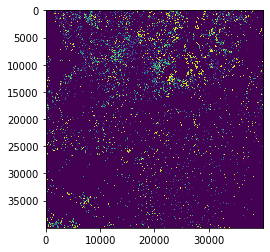

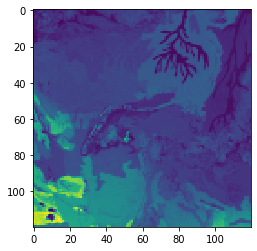

/usr/local/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


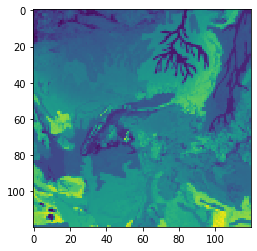

Splitting year 2001
Splitting year 2002
Splitting year 2003
Splitting year 2004
Splitting year 2005
Splitting year 2006
Splitting year 2007
Splitting year 2008
Splitting year 2009
Splitting year 2010
Splitting year 2011
Splitting year 2012
Splitting year 2013
Splitting year 2014
Splitting year 2015
Splitting year 2016
Splitting year 2017
Splitting year 2018


In [6]:
# load data
data_dict = load_data(path_dict)


In [9]:
# grid data
grid_dict = grid_data(data_dict, GRID_SIZE)


In [10]:
# write data to csv
write_csv(grid_dict, GRID_SIZE)
